In [203]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import pandas as pd
import json
import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from matplotlib.patches import Rectangle
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from scipy.interpolate import griddata

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [204]:
def plot_as_heatmap(ax, x, y, z, n_points=1000, cmap="viridis", norm=None, interpolation="linear"):
    x_min, x_max = min(x), max(x)
    y_min, y_max = min(y), max(y)
    X, Y = np.meshgrid(np.linspace(x_min, x_max, n_points), np.linspace(y_min, y_max, n_points))
    Z = griddata((x, y), z, (X, Y), method=interpolation)
    pcm = ax.imshow(Z, extent=[x_min, x_max, y_min, y_max], origin="lower", cmap=cmap, norm=norm)
    return pcm

def plot_2d_hypercube(ax, hypercube, color="C0", alpha=0.4, label=None):
    barycenter = hypercube.center()
    side_lengths = hypercube.side_lengths()
    anchor = barycenter - side_lengths / 2
    square = Rectangle(anchor, side_lengths[0], side_lengths[1], edgecolor=color, facecolor=color, alpha=alpha, label=label)
    
    # ax.plot(barycenter[0], barycenter[1], "o", color=color)
    ax.add_patch(square)
    return square

## 1. Data Generation

In [205]:
# 2D functions used to compute targets
def sin_sqrt(X):
    return np.sin(np.sqrt(X[:, 0]**2 + X[:, 1]**2))

def booth(X):
    X1, X2 = X[:, 0], X[:, 1]
    return ((X1 + 2*X2 - 7)**2 + (2*X1 + X2 - 5)**2)

def goldstein_price(X):
    X1, X2 = X[:, 0], X[:, 1]
    return ((1+(X1 + X2 + 1)**2*(19-14*X1+3*X1**2-14*X2+6*X1*X2+3*X2**2))*(30+(2*X1-3*X2)**2*(18-32*X1+12*X1**2+48*X2-36*X1*X2+27*X2**2)))

def beale(X):
    X1, X2 = X[:, 0], X[:, 1]
    return (1.5 - X1 + X1*X2)**2 + (2.25 - X1 + X1*X2**2)**2 + (2.625 - X1 + X1*X2**3)**2

# function to generate 2D input data
def generate_X(n_samples, ranges=[(0, 1), (0, 1)], random_state=None):
    dim = len(ranges)
    assert dim > 0
    rng = np.random.default_rng(random_state)
    X = np.zeros((n_samples, dim))
    for i, r in enumerate(ranges):
        low, high = r
        X[:, i] = rng.uniform(low, high, n_samples)
    return X

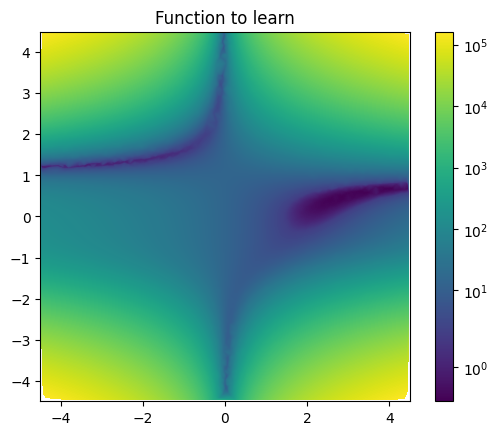

In [282]:
seed = 42
n_samples = 10000
fn = beale
features = generate_X(n_samples, ranges=[(-4.5, 4.5), (-4.5, 4.5)], random_state=seed)
targets = fn(features)

X_train, X_test, y_train, y_test = train_test_split(features, targets , test_size=0.2)

fig = plt.gcf()
ax = plt.gca()
pcm = plot_as_heatmap(ax, features[:, 0], features[:, 1], targets, norm="symlog")
ax.set_title("Function to learn")
fig.colorbar(pcm)

## 2. Preprocessing

In [283]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler((-1, 1))
scaler.fit(X_train)

MinMaxScaler(feature_range=(-1, 1))

## 3. Training

In [284]:
from mas import head

model = head.FastHeadAgent(
    R=np.full(2, 0.1),
    alpha=0.2,
    bad_th=0.3,
    imprecise_th=0.1,
    memory_length=20,
    min_vol=0.
)

model.fit(scaler.transform(X_train), y_train, epochs=5, verbose=True)

[agents: 1262 | maturity: 0.00% | vol+: 0.1111 | vol-: -4.3512]: 100%|██████████| 8000/8000 [00:17<00:00, 468.26it/s]
[agents: 1965 | maturity: 39.54% | vol+: 0.0750 | vol-: -2.0401]: 100%|██████████| 8000/8000 [00:18<00:00, 434.79it/s]
[agents: 2429 | maturity: 49.94% | vol+: 0.0593 | vol-: -0.9094]: 100%|██████████| 8000/8000 [00:18<00:00, 428.77it/s]
[agents: 2702 | maturity: 60.92% | vol+: 0.0521 | vol-: -0.4777]: 100%|██████████| 8000/8000 [00:18<00:00, 429.88it/s]
[agents: 2883 | maturity: 67.88% | vol+: 0.0368 | vol-: -0.2952]: 100%|██████████| 8000/8000 [00:19<00:00, 409.47it/s]


## 4. Visualization

In [285]:
from mas.hypercube import *

Text(0.5, 1.0, 'Predictions on test set')

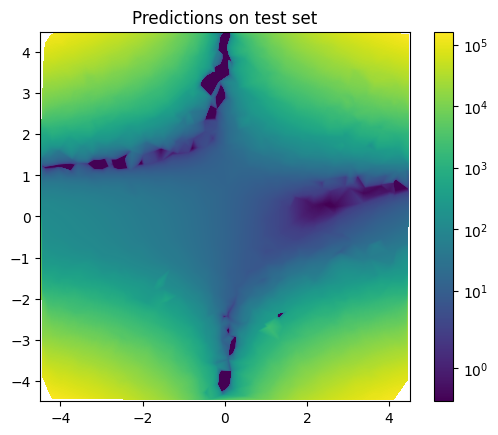

In [286]:
y_pred = model.predict(scaler.transform(X_test))

ax = plt.gca()
# pcm = plot_as_heatmap(ax, X_test[:, 0], X_test[:, 1], y_test, norm="symlog", interpolation="linear")
pcm = plot_as_heatmap(ax, X_test[:, 0], X_test[:, 1], y_pred, norm="symlog", interpolation="linear")
pcm.set_clim(min(y_test), max(y_test))
plt.colorbar(pcm)
plt.title("Predictions on test set")

Text(0, 0.5, 'Y')

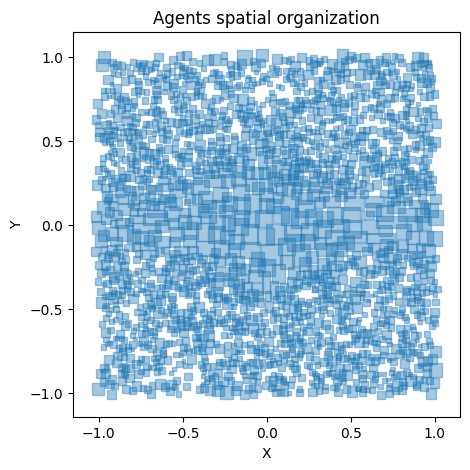

In [293]:
plt.figure(figsize=(5, 5))

ax = plt.gca()
ax.scatter(scaler.transform(X_train)[:, 0], scaler.transform(X_train)[:, 1], marker="o", c="r", alpha=0)

for a in model.context_agents.values():
    plot_2d_hypercube(ax, a.validity)
ax.set_title("Agents spatial organization")
ax.set_xlabel("X")
ax.set_ylabel("Y")

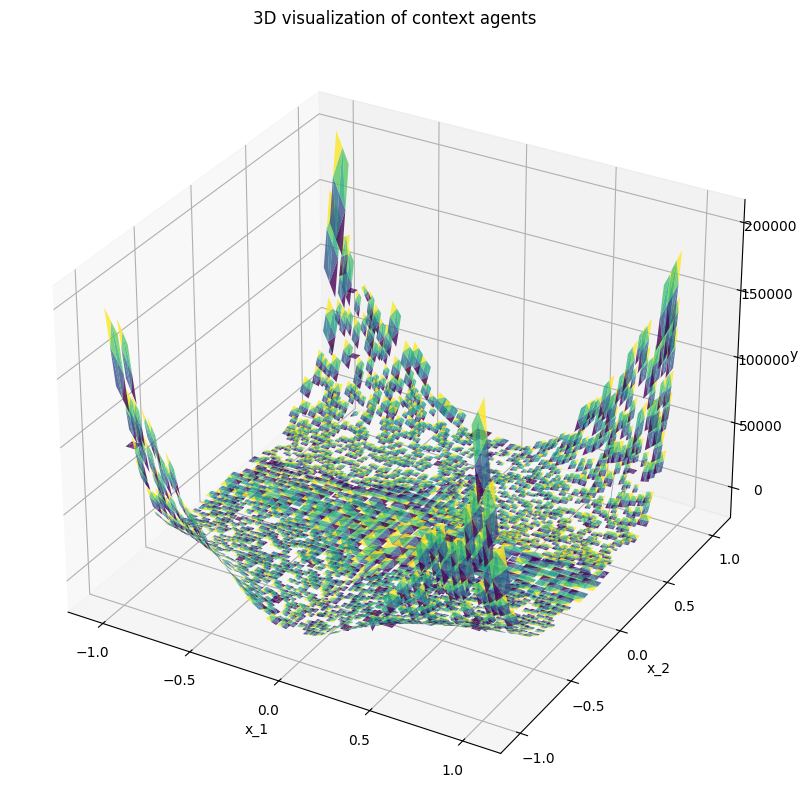

In [288]:
def plot_3d_agent(ax, agent, n_points=3, alpha=0.2, color="C0"):
    if agent.is_mature():
        l, h = agent.validity.low[:2], agent.validity.high[:2]
        X = np.linspace(l[0], h[0], n_points)
        Y = np.linspace(l[1], h[1], n_points)
        X, Y = np.meshgrid(X, Y)
        features = np.vstack([X.flatten(), Y.flatten()]).T
        y = agent.predict(features)
        ax.plot_trisurf(features[:, 0], features[:, 1], y.ravel(), alpha=alpha, color=color, cmap="viridis")

fig, axs = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(10, 10))
axs.set_xlabel("x_1")
axs.set_ylabel("x_2")
axs.set_zlabel("y")
axs.set_title("3D visualization of context agents")

for a in model.context_agents.values():
    c = "C0"
    plot_3d_agent(axs, a, alpha=0.8)

#### Degree of discrepancy

100%|██████████| 2000/2000 [00:03<00:00, 570.85it/s]


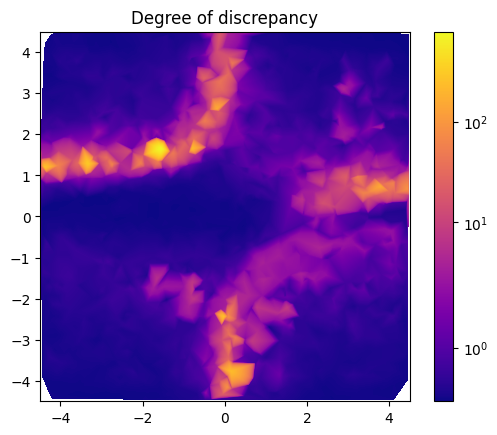

In [289]:
def discrepancy(obs, neighborhood_agents):
    preds = [a.predict(obs) for a in neighborhood_agents]
    return np.std(preds), np.mean(preds)


pbar = tqdm.tqdm(scaler.transform(X_test))

discrepancies = []
for x in pbar:
    neighborhood = AdaptiveHypercube(x, model.R * 2)
    neighborhood_agents = [model.context_agents[i] for i in model.agent_index.intersection(neighborhood.bounding_box)]
    std, mean = discrepancy(x, neighborhood_agents)
    discrepancies.append(std) 

discrepancies = np.array(discrepancies)
degree_of_discrepancy = discrepancies / np.abs(y_pred)

ax = plt.gca()
pcm = plot_as_heatmap(ax, X_test[:, 0], X_test[:, 1], degree_of_discrepancy, n_points=1000, cmap="plasma", norm="symlog")
plt.title("Degree of discrepancy")
plt.colorbar(pcm)
plt.show()

#### Density

100%|██████████| 2000/2000 [00:00<00:00, 15309.24it/s]


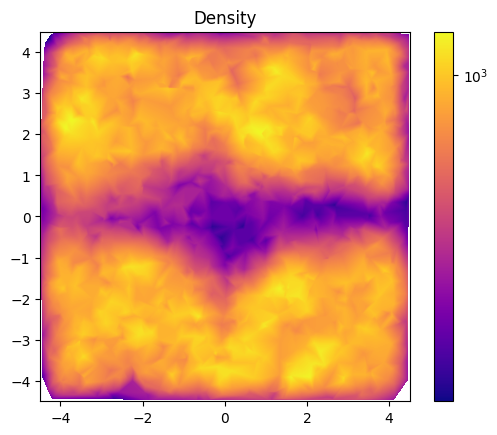

In [290]:
pbar = tqdm.tqdm(scaler.transform(X_test))

densities = []
for x in pbar:
    neighborhood = AdaptiveHypercube(x, model.R * 2)
    neighborhood_agents = [model.context_agents[i] for i in model.agent_index.intersection(neighborhood.bounding_box)]
    n_neighbors = len(neighborhood_agents)
    density = n_neighbors / neighborhood.volume()
    densities.append(density)

densities = np.array(densities)
ax = plt.gca()
pcm = plot_as_heatmap(ax, X_test[:, 0], X_test[:, 1], densities, n_points=1000, cmap="plasma", norm="symlog")
plt.title("Density")
plt.colorbar(pcm)
plt.show()

#### Mean Volume

100%|██████████| 2000/2000 [00:00<00:00, 4346.42it/s]


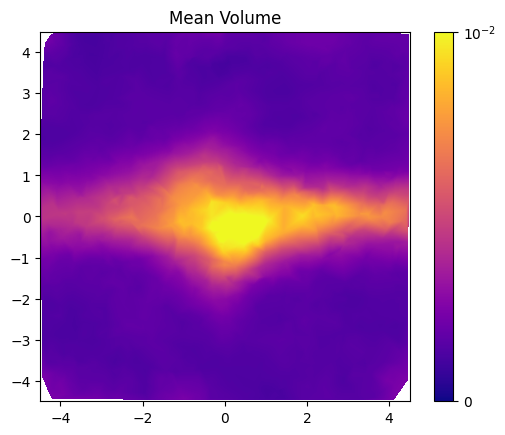

In [291]:
pbar = tqdm.tqdm(scaler.transform(X_test))

mean_vols = []
for x in pbar:
    neighborhood = AdaptiveHypercube(x, model.R * 2)
    neighborhood_agents_volume = [model.context_agents[i].validity.volume() for i in model.agent_index.intersection(neighborhood.bounding_box)]
    v = np.mean(neighborhood_agents_volume)
    mean_vols.append(v)

mean_vols = np.array(mean_vols)
ax = plt.gca()
pcm = plot_as_heatmap(ax, X_test[:, 0], X_test[:, 1], mean_vols, n_points=1000, cmap="plasma", norm="symlog")
pcm.set_clim(np.round(min(mean_vols), decimals=2), np.round(max(mean_vols), decimals=2))
plt.title("Mean Volume")
plt.colorbar(pcm)
plt.show()

#### Usefulness of coverage index

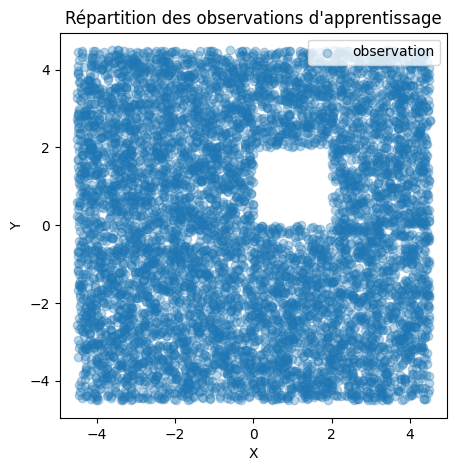

In [297]:
fig = plt.figure(figsize=(5, 5))
x_l, x_h = 0, 2
y_l, y_h = 0, 2

x = X_train[:, 0]
y = X_train[:, 1]
x_mask = (x > x_l) & (x < x_h)
y_mask = (y > y_l) & (y < y_h)
X_train_crop = X_train[~(x_mask & y_mask)]
y_train_crop = y_train[~(x_mask & y_mask)]


plt.scatter(X_train_crop[:, 0], X_train_crop[:, 1], alpha=0.3, label="observation")
plt.title("Répartition des observations d'apprentissage")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc="upper right")

In [299]:
r_coeff = 0.1
crop_model = head.FastHeadAgent(
    R=np.full(2, r_coeff),
    imprecise_th=0.01,
    bad_th=0.5,
    alpha=0.2,
    min_vol=0.,
    memory_length=200,
)

crop_model.fit(scaler.transform(X_train_crop), y_train_crop, epochs=5, verbose=True)


[agents: 1214 | maturity: 0.00% | vol+: 0.1137 | vol-: -4.2370]: 100%|██████████| 7585/7585 [00:18<00:00, 420.45it/s]
[agents: 1874 | maturity: 39.11% | vol+: 0.0803 | vol-: -1.8798]: 100%|██████████| 7585/7585 [00:20<00:00, 375.76it/s]
[agents: 2295 | maturity: 52.42% | vol+: 0.0366 | vol-: -0.8725]: 100%|██████████| 7585/7585 [00:20<00:00, 364.38it/s]
[agents: 2573 | maturity: 61.17% | vol+: 0.0270 | vol-: -0.4587]: 100%|██████████| 7585/7585 [00:21<00:00, 358.32it/s]
[agents: 2716 | maturity: 69.70% | vol+: 0.0196 | vol-: -0.2741]: 100%|██████████| 7585/7585 [00:22<00:00, 333.50it/s]


Text(0, 0.5, 'Y')

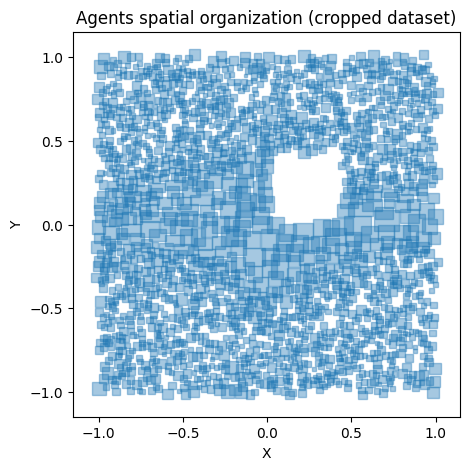

In [315]:
plt.figure(figsize=(5, 5))

ax = plt.gca()
ax.scatter(scaler.transform(X_train)[:, 0], scaler.transform(X_train)[:, 1], marker="o", c="r", alpha=0)

for a in crop_model.context_agents.values():
    plot_2d_hypercube(ax, a.validity)
ax.set_title("Agents spatial organization (cropped dataset)")
ax.set_xlabel("X")
ax.set_ylabel("Y")

In [324]:
def coverage_index(neighborhood, neighborhood_agents, n_samples=100):
    hypercubes = [overlap(a.validity, neighborhood) for a in neighborhood_agents]
    if len(hypercubes) == 0:
        return 0
    x_, y_ = np.meshgrid(*[np.linspace(l, h, int(np.sqrt(n_samples))) for l, h in zip(neighborhood.low, neighborhood.high)])
    x_, y_ = x_.flatten(), y_.flatten()
    samples = np.stack([x_, y_]).T
    nb_overlapped = 0
    for s in samples:
        overlapped = False
        for h in hypercubes:
            overlapped = h.contains(s).all()
            if overlapped:
                nb_overlapped += 1
                break
    return (nb_overlapped * neighborhood.volume() / n_samples)/ neighborhood.volume()

pbar = tqdm.tqdm(scaler.transform(X_test))

coverage_indexs = []
for x in pbar:
    neighborhood = AdaptiveHypercube(x, model.R * 2)
    neighborhood_agents = [crop_model.context_agents[i] for i in crop_model.agent_index.intersection(neighborhood.bounding_box)]
    cov_index = coverage_index(neighborhood, neighborhood_agents)
    coverage_indexs.append(cov_index)

coverage_indexs = np.array(coverage_indexs)

100%|██████████| 2000/2000 [00:12<00:00, 165.55it/s]


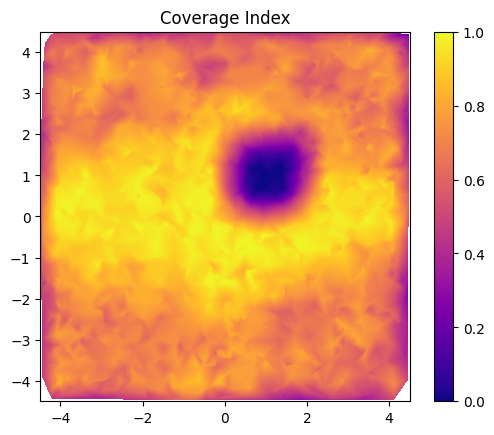

In [325]:
ax = plt.gca()
pcm = plot_as_heatmap(ax, X_test[:, 0], X_test[:, 1], coverage_indexs, n_points=1000, cmap="plasma")
pcm.set_clim(np.round(min(coverage_indexs), decimals=2), np.round(max(coverage_indexs), decimals=2))
plt.title("Coverage Index")
plt.colorbar(pcm)
plt.show()